In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Question 1

In [4]:
def load_glove(filepath):
    vectors = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            splits = line.split()
            vectors[splits[0]] = np.asarray(splits[1:], dtype='float32')
    return vectors

def glove_features(text, vector):
    words = text.split()
    size = len(next(iter(vector.values())))
    word_vectors = [vector[w] for w in words if w in vector]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(size)

nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


# Function to remove special characters and lemmatize
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text.lower())])
    return text

def cross_val(data, labels, model, splits=5):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    results_train = []
    results_val = []

    for train_idx, val_idx in kf.split(data):
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        model.fit(X_train, y_train)
        results_train.append(model.score(X_train, y_train))
        results_val.append(model.score(X_val, y_val))

    return [np.mean(results_train), np.std(results_train),
            np.mean(results_val), np.std(results_val)]

def make_plot(df, metric_type):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(df))
    bar_width = 0.5

    plt.bar(x - bar_width/2, df['Train_Acc'], bar_width, yerr=df['Train_Std'], label='Train', color='red', capsize=5)
    plt.bar(x + bar_width/2, df['Val_Acc'], bar_width, yerr=df['Val_Std'], label='Validation', color='blue', capsize=5)

    plt.xlabel(metric_type)
    plt.ylabel('Accuracy')
    plt.title(f'Performance by {metric_type}')
    plt.xticks(x, df.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saisr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saisr\AppData\Roaming\nltk_data...


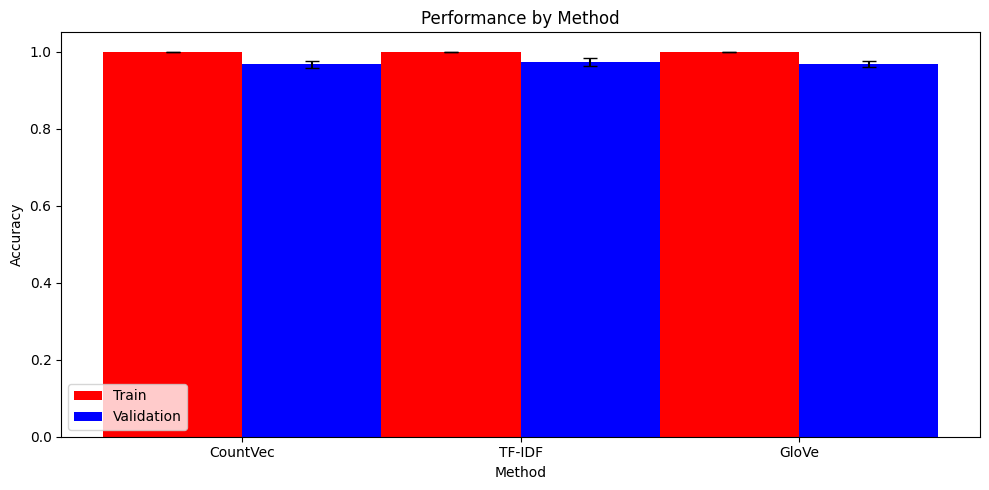

In [7]:
with tf.device('/GPU:0'):
  train_df = pd.read_csv('./24_train_1.csv')
  test_df = pd.read_csv('./news-test.csv')

  train_df['processed_text'] = train_df['Text'].apply(preprocess_text)
  test_df['processed_text'] = test_df['Text'].apply(preprocess_text)

  le = LabelEncoder()
  y_numeric = le.fit_transform(train_df['Category'])

  base_nn = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300, random_state=42)

  cnt = CountVectorizer(max_features=10000)
  tfidf = TfidfVectorizer(max_features=10000)
  glv = load_glove('./glove.6B.100d.txt')

  X_count = cnt.fit_transform(train_df['processed_text']).toarray()
  X_tfidf = tfidf.fit_transform(train_df['processed_text']).toarray()
  X_glove = np.array([glove_features(text, glv) for text in train_df['processed_text']])

  train_accs, train_stds, val_accs, val_stds = [], [], [], []

  for feat_data in [X_count, X_tfidf, X_glove]:
      metrics = cross_val(feat_data, y_numeric, base_nn)
      train_accs.append(metrics[0])
      train_stds.append(metrics[1])
      val_accs.append(metrics[2])
      val_stds.append(metrics[3])


  feature_metrics = pd.DataFrame({
      'Train_Acc': train_accs,
      'Train_Std': train_stds,
      'Val_Acc': val_accs,
      'Val_Std': val_stds
  }, index=['CountVec', 'TF-IDF', 'GloVe'])

  make_plot(feature_metrics, 'Method')


In [8]:
feature_metrics

,Train_Acc,Train_Std,Val_Acc,Val_Std
CountVec,1.0,0.0,0.967,0.009274
TF-IDF,1.0,0.0,0.973,0.010296
GloVe,1.0,0.0,0.968,0.008718


# Question 2


=== Learning Rate Analysis Results ===
       Train_Acc Train_Std Val_Acc   Val_Std
0.0001       1.0       0.0   0.972  0.009798
0.0003       1.0       0.0   0.973  0.012083
0.0010       1.0       0.0   0.973  0.010296
0.0030       1.0       0.0   0.974  0.008602
0.0100       1.0       0.0   0.963  0.009274
0.0300       1.0       0.0   0.933  0.008124
0.1000       1.0       0.0    0.95  0.008367


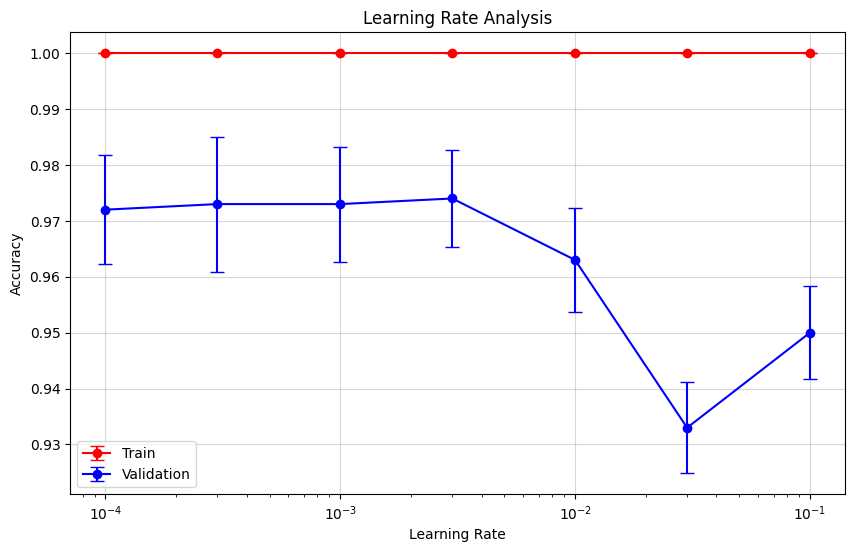

In [9]:
with tf.device('/GPU:0'):

  lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
  metrics = pd.DataFrame(
      columns=['Train_Acc', 'Train_Std', 'Val_Acc', 'Val_Std'],
      index=lrs
  )

  for lr in lrs:
      model = MLPClassifier(
          hidden_layer_sizes=(128, 128),
          max_iter=300,
          learning_rate_init=lr,
          random_state=42
      )
      lr_metrics = cross_val(X_tfidf, y_numeric, model)
      metrics.loc[lr] = lr_metrics

  print("\n=== Learning Rate Analysis Results ===")
  print(metrics.round(4))

  plt.figure(figsize=(10, 6))
  plt.errorbar(metrics.index, metrics['Train_Acc'], yerr=metrics['Train_Std'], fmt='o-', label='Train', color='red', capsize=5)
  plt.errorbar(metrics.index, metrics['Val_Acc'], yerr=metrics['Val_Std'], fmt='o-', label='Validation', color='blue', capsize=5)
  plt.xscale('log')
  plt.grid(True, alpha=0.5)
  plt.xlabel('Learning Rate')
  plt.ylabel('Accuracy')
  plt.title('Learning Rate Analysis')
  plt.legend()
  plt.show()


# Question 3

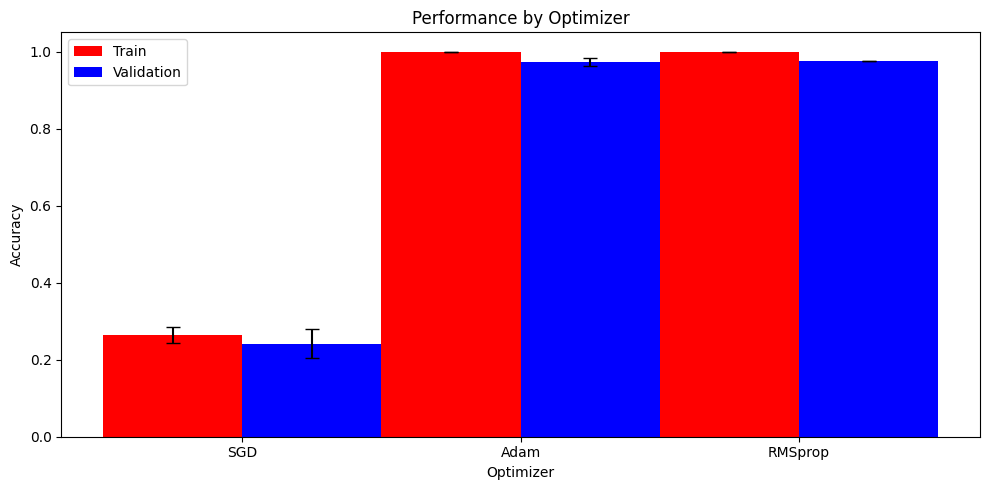

        Train_Acc Train_Std Val_Acc   Val_Std
SGD         0.264  0.021219   0.242  0.038678
Adam          1.0       0.0   0.973  0.009274
RMSprop       1.0       0.0   0.975       0.0


In [11]:
def make_model(input_dim, num_classes, opt):
    optimizers = {
        'SGD': SGD(learning_rate=0.003),
        'Adam': Adam(learning_rate=0.003),
        'RMSprop': RMSprop(learning_rate=0.003)
    }

    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers[opt],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

results_by_optimizer = pd.DataFrame(
    index=['SGD', 'Adam', 'RMSprop'],
    columns=['Train_Acc', 'Train_Std', 'Val_Acc', 'Val_Std']
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_classes = len(np.unique(y_numeric))

for opt in results_by_optimizer.index:
    train_scores, val_scores = [], []

    for train_idx, val_idx in kf.split(X_tfidf):
        X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
        y_train, y_val = y_numeric[train_idx], y_numeric[val_idx]

        model = make_model(X_train.shape[1], num_classes, opt)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        train_scores.append(model.evaluate(X_train, y_train, verbose=0)[1])
        val_scores.append(model.evaluate(X_val, y_val, verbose=0)[1])

    results_by_optimizer.loc[opt] = [
        np.mean(train_scores), np.std(train_scores),
        np.mean(val_scores), np.std(val_scores)
    ]

make_plot(results_by_optimizer, 'Optimizer')

print(results_by_optimizer)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4732 - loss: 1.3579 - val_accuracy: 0.9650 - val_loss: 0.2899
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9932 - loss: 0.1049 - val_accuracy: 0.9300 - val_loss: 0.1728
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9995 - loss: 0.0112 - val_accuracy: 0.9700 - val_loss: 0.1032
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9700 - val_loss: 0.0878
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9700 - val_loss: 0.0829
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.7906e-04 - val_accuracy: 0.9750 - val_loss: 0.0789
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 3.5866e-04 - val_accuracy: 0.9750 - val_loss: 0.0761
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.4053e-04 - val_accuracy

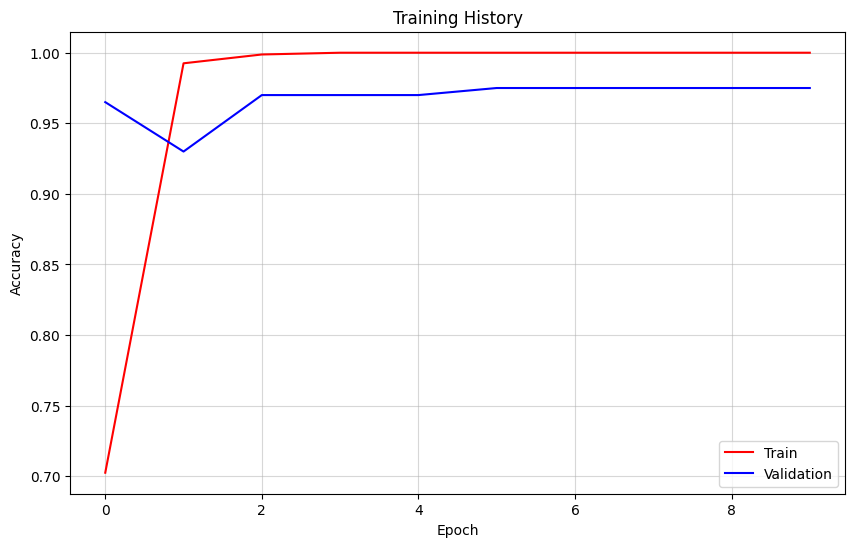

In [12]:
tfidf_fin = TfidfVectorizer(max_features=10000)
X_train = tfidf_fin.fit_transform(train_df['processed_text']).toarray()
X_test = tfidf_fin.transform(test_df['processed_text']).toarray()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_numeric, test_size=0.2, random_state=42
)

final_model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

final_model.compile(
    optimizer=RMSprop(learning_rate=0.003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = final_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

predictions = final_model.predict(X_test)
pred_labels = le.inverse_transform(predictions.argmax(axis=-1))

pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': pred_labels
}).to_csv('labels.csv', index=False, header=False)

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train', color='red')
plt.plot(history.history['val_accuracy'], label='Validation', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [14]:
print("\nFeature Extraction Results")
print(feature_metrics.round(4).to_string())

print("\nLearning Rate Analysis Results")
print(metrics.round(4).to_string())

print("\nResults by Optimizer")
print(results_by_optimizer.round(4).to_string())

print("\nFinal Model Performance")
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_results = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Validation Accuracy'],
    'Value': [final_train_acc, final_val_acc]
}).set_index('Metric')
print(final_results.round(4).to_string())


Feature Extraction Results
          Train_Acc  Train_Std  Val_Acc  Val_Std
CountVec        1.0        0.0    0.967   0.0093
TF-IDF          1.0        0.0    0.973   0.0103
GloVe           1.0        0.0    0.968   0.0087

Learning Rate Analysis Results
       Train_Acc Train_Std Val_Acc   Val_Std
0.0001       1.0       0.0   0.972  0.009798
0.0003       1.0       0.0   0.973  0.012083
0.0010       1.0       0.0   0.973  0.010296
0.0030       1.0       0.0   0.974  0.008602
0.0100       1.0       0.0   0.963  0.009274
0.0300       1.0       0.0   0.933  0.008124
0.1000       1.0       0.0    0.95  0.008367

Results by Optimizer
        Train_Acc Train_Std Val_Acc   Val_Std
SGD         0.264  0.021219   0.242  0.038678
Adam          1.0       0.0   0.973  0.009274
RMSprop       1.0       0.0   0.975       0.0

Final Model Performance
                     Value
Metric                    
Training Accuracy    1.000
Validation Accuracy  0.975
